# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

Aim and Objectives:
* Transform and analyse raw, tabular daily_temp_tsdf from a statistics website.
* Apply multiple machine-learning techniques to this daily_temp_tsdf.
* Investigate and document ethical and social implications.
* Create a data project and analysis related to real-life statistics.
* Deadline: 10th January 2024

Deliverables:
* 20 Pages (Maximum) Document in the IEEE Access format
* Project GitHub Pages Webpage
* 10 Page (Maximum) Generative AI Usage Journal

**IMPORTANT**: For dependencies, running and committing this notebooks, see: [README](./README.md)

## Problem: Given the Climate and Population Trends, Can we forcecast Electricity Demands?

Model Outcomes:
* Energy Demand Forecasting
* Risk - Outages, Climate, etc?

# Data Preparation & Wrangling

### Provenance
Electricity:
- [NSO Excel: Electricity supply by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Gross production of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Electricity production from power plants by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Estimated electricity production from renewable sources by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Imports and exports of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Electricity supply by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [Malta Resources Authority tableau: GHG emissions by year](https://public.tableau.com/app/profile/maltaresourcesauthority/viz/test_16911097613970/BySector)
- [Eurostat CSV: Net electricity generation by type of fuel - monthly data](https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_pem__custom_8232363/default/table?lang=en)

Climate:
- [Meteostat: Temperature](https://dev.meteostat.net/sources.html)

Population:
- [Worldbank CSV: Population](https://data.worldbank.org/country/malta)

Indutrial Indices:
- [Worldbank CSV: GDP in Local Currency Unit (Euro)](https://data.worldbank.org/indicator/NY.GDP.MKTP.CN.AD?locations=MT&view=chart)

### Processing

* **Manual** edit of CSV to delete text, disclaimers and images from NSO. Output is a clean table.
* Removal of **features with >20% NaNs**. Too many gaps to interpolate.
* Drop data **> 3 standard deviations**.
* Resample to 22years from **2000 to 2022**.
* Normalize and reduce data. E.g. Mega Watts to Giga Watts, Minutes to Days, etc.
* Linear **interpolation of NaNs**.

In [1]:
import os
import re

import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt

$$ R_{i} = \alpha_i + \sum(\beta_{i,F_i}) + \epsilon_{it}
$$

## Electricity Demand and Production

These timeseries have been scraped from the NSO publications. The data-quality is moderate, requiring resampling, inputting of missing datapoints, and scaling to the giga scale.

In [2]:
# Constants here
START_DATE = datetime(2003, 1, 1)
END_DATE = datetime(2022, 12, 31)

# All unprocessed CVs should go here.
RAW_DATA_PATH = "./raw_data"

# Base electricity datasets
SELECTED_FEATURES = []
ELEC_DMD_COL = "Max_Demand_GW"
ELEC_PROD_COL = "Plant_Production_GWh"
ELECTRIC_MW_DS = [
    "Max_Demand_MW.csv",
    "Plant_Production_MWh.csv",
    "Imports_MWh.csv",
    "Renewables_Production_MWh.csv",
]
MEGA_TO_GIGA = 1000

all_data_df = pd.DataFrame()
for filename in ELECTRIC_MW_DS:
    file_path = os.path.join(RAW_DATA_PATH, filename)
    # Convert mega to giga
    value_col = filename.split(".")[0].replace("_MW", "_GW")
    print(f"Processing: {filename}")

    df = pd.read_csv(file_path)

    # We will melt month (y-index) and year (x-index) to
    # create an index for each feature timeseries
    melted_df = df.melt(id_vars=["Month"], var_name="Year", value_name=value_col)
    melted_df[value_col] = melted_df[value_col].apply(
        # Clean - Values from string to scalar. Drop non-numeric characters (e.g. ,)
        lambda x: float(re.sub("[^0-9.]", "", str(x))) / MEGA_TO_GIGA
        if isinstance(x, (str))
        else float(x / MEGA_TO_GIGA)
    )

    # set the index of Year-month, this will be for all timeseries
    melted_df["Date"] = pd.to_datetime(
        melted_df["Month"] + " " + melted_df["Year"], format="%B %Y"
    )
    melted_df.set_index("Date", inplace=True, drop=True)

    min_date = melted_df.index.min()
    max_date = melted_df.index.max()
    nan_count = melted_df[value_col].isnull().sum()
    skewness = round(skew(melted_df[value_col].dropna()), 2)
    kurt = round(kurtosis(melted_df[value_col].dropna()), 2)
    outliers_count = (
        melted_df[value_col]
        > melted_df[value_col].mean() + 3 * melted_df[value_col].std()
    ).sum()
    print(
        f"Stats => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
    )

    # Do we have long tails? Do we have extremes?
    melted_df[value_col] = melted_df[value_col].resample("MS").ffill()
    # drop long floating points
    melted_df[value_col] = round(melted_df[value_col], 2)
    melted_df = melted_df[
        (melted_df.index >= START_DATE) & (melted_df.index <= END_DATE)
    ]
    if all_data_df is None:
        all_data_df = melted_df[value_col]
    else:
        all_data_df[value_col] = melted_df[value_col]
        all_data_df[value_col] = all_data_df[value_col].interpolate().fillna(0)

SELECTED_FEATURES.append(ELEC_DMD_COL)
SELECTED_FEATURES.append(ELEC_PROD_COL)

all_data_df[SELECTED_FEATURES].tail(3)

Processing: Max_Demand_MW.csv
Stats => min_date: 2003-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:1.55, skewness:1.09, outliers_count:4,  nan_count: 0
Processing: Plant_Production_MWh.csv
Stats => min_date: 2003-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:2.0, skewness:1.33, outliers_count:3,  nan_count: 0
Processing: Imports_MWh.csv
Stats => min_date: 2015-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:-0.77, skewness:0.31, outliers_count:0,  nan_count: 0
Processing: Renewables_Production_MWh.csv
Stats => min_date: 2013-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:-0.69, skewness:0.29, outliers_count:0,  nan_count: 60


,Max_Demand_GW,Plant_Production_GWh
Date,,
2022-10-01,0.41,225.89
2022-11-01,0.41,206.40
2022-12-01,0.40,207.78


Given the data quality, we detected skewness and curtosis and should be anaylzed visually.

We can see that further down the timescale past 2015 and 2019, Malta has gone through regime changes in economy, population and demand - enlarging the diffusion of the data:

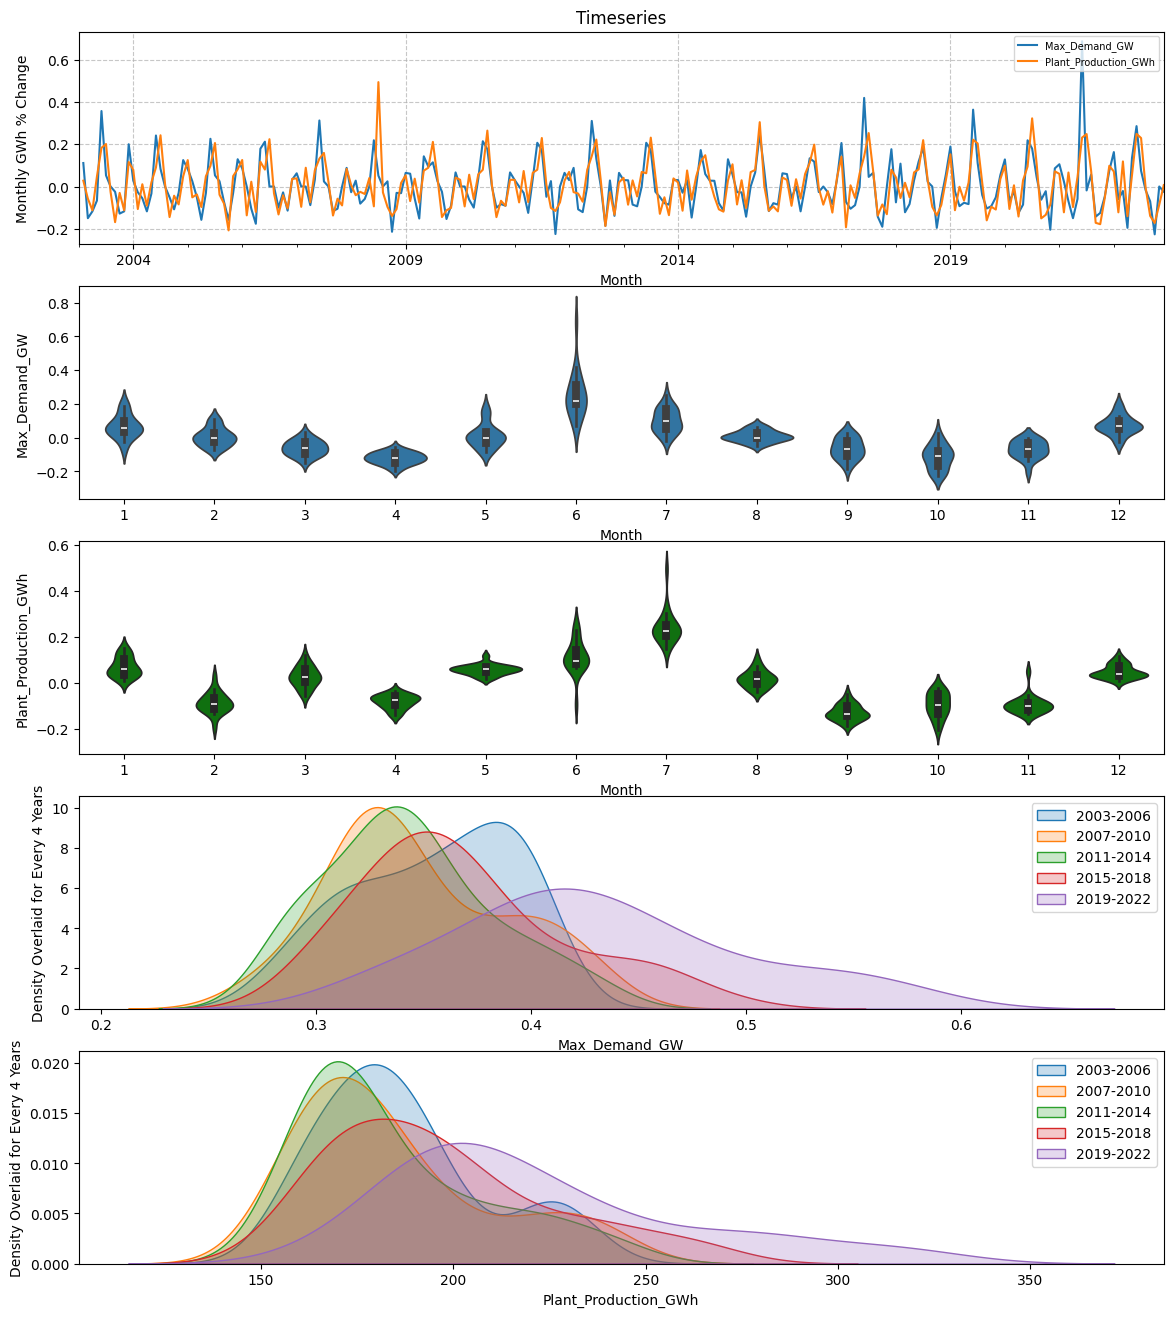

In [3]:
import seaborn as sns


# Visually check if data is healthy
fig, axes = plt.subplots(5, 1, figsize=(14, 16))
for col in SELECTED_FEATURES:
    all_data_df[col].pct_change().ffill().plot(kind="line", ax=axes[0], label=col)
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Monthly GWh % Change")
axes[0].grid(axis="both", linestyle="--", alpha=0.7)
axes[0].set_title("Timeseries")
axes[0].legend(fontsize=7, loc="upper right")

sampling_subset = pd.DataFrame(all_data_df[ELEC_DMD_COL].pct_change().ffill().copy())
sampling_subset["Month"] = sampling_subset.index.month
sns.violinplot(x="Month", y=ELEC_DMD_COL, data=sampling_subset, ax=axes[1])
sampling_subset = pd.DataFrame(all_data_df[ELEC_PROD_COL].pct_change().ffill().copy())
sampling_subset["Month"] = sampling_subset.index.month
sns.violinplot(
    x="Month", y=ELEC_PROD_COL, data=sampling_subset, ax=axes[2], color="green"
)

# Distribution per Month will be used for weights for synthetic data
# for the rest, we observe skewness and outliers.
axes[3].set_xlabel(f"{ELEC_DMD_COL}")
axes[3].set_ylabel("Density Overlaid for Every 4 Years")
for start_year in range(all_data_df.index.year.min(), all_data_df.index.year.max(), 4):
    end_year = start_year + 3
    year_data = all_data_df[
        (all_data_df.index.year >= start_year) & (all_data_df.index.year <= end_year)
    ]
    sns.kdeplot(
        year_data[ELEC_DMD_COL],
        ax=axes[3],
        fill=True,
        label=f"{start_year}-{end_year}",
    )
axes[3].legend()

axes[4].set_xlabel(f"{ELEC_PROD_COL}")
axes[4].set_ylabel("Density Overlaid for Every 4 Years")
for start_year in range(all_data_df.index.year.min(), all_data_df.index.year.max(), 4):
    end_year = start_year + 3
    year_data = all_data_df[
        (all_data_df.index.year >= start_year) & (all_data_df.index.year <= end_year)
    ]
    sns.kdeplot(
        year_data[ELEC_PROD_COL],
        ax=axes[4],
        fill=True,
        label=f"{start_year}-{end_year}",
    )
axes[4].legend()

plt.show()

## C02 Emissions

In addition, we want to explore the emissions affect on the demand and other features.

Emissions timeseries had moderate quality, having to be resampled every month and interpolated for fill gaps. Additionally, inputting of monthly emissions was performed by scaling he yearly amount to monthly, weighted by the NSO's provided power output at monthly distribution:

$$
\begin{equation}
    \text{Monthly C02}_i = \left( \frac{\text{Annual Demand}_i}{12} \right) \times \frac{\text{Monthly Demand}_i}{\text{Annual Demand}_i}
\end{equation}
$$

In [4]:
# the Datasets below need unique data wrangling
C02_DS = "emissions_c02_g.csv"
CO2_COL = "emissions_c02_GG"
GRAMS_TO_GIGA = 1e-9

c02_df = pd.read_csv(os.path.join(RAW_DATA_PATH, C02_DS))
c02_df["Year"] = pd.to_datetime(c02_df["Year"], format="%Y")
c02_df.set_index("Year", drop=True, inplace=True)
c02_df.rename(columns={"Emissions": CO2_COL}, inplace=True)
c02_df = c02_df.groupby("Year")[CO2_COL].sum()
c02_df = (
    c02_df.resample("MS")
    .ffill()
    .to_frame(name=CO2_COL)
    .sort_values(by="Year", ascending=True)
)

# Break yearly into monthly.
extended_index = pd.date_range(start=c02_df.index.min(), end="2022-12-01", freq="MS")
c02_df = c02_df.reindex(extended_index)
c02_df["Totals"] = c02_df[CO2_COL]
c02_df[CO2_COL] /= 12
c02_df = c02_df.ffill()
corr = all_data_df[ELEC_DMD_COL].corr(c02_df[CO2_COL])
print(f"Corr coeff: {corr:0.02f}")

# We will interpolate CO2 production using the plants monthly supply as weights.
sampling_subset = pd.DataFrame(all_data_df[ELEC_DMD_COL].copy())
sampling_subset = sampling_subset.resample("MS").ffill()
sampling_subset["total"] = sampling_subset.groupby(sampling_subset.index.year)[
    ELEC_DMD_COL
].transform("sum")
sampling_subset["weights"] = sampling_subset[ELEC_DMD_COL] / sampling_subset["total"]
print(sampling_subset["weights"].head(12))

c02_df[CO2_COL] = round(sampling_subset["weights"] * (c02_df[CO2_COL]), 2)
c02_df = c02_df[(c02_df.index >= START_DATE) & (c02_df.index <= END_DATE)]

Corr coeff: 0.38
Date
2003-01-01    0.084706
2003-02-01    0.094118
2003-03-01    0.080000
2003-04-01    0.070588
2003-05-01    0.065882
2003-06-01    0.089412
2003-07-01    0.094118
2003-08-01    0.094118
2003-09-01    0.091765
2003-10-01    0.080000
2003-11-01    0.070588
2003-12-01    0.084706
Freq: MS, Name: weights, dtype: float64


Visualize the quality and outcome of wrangling on this timeseries. CO2 should move with the production timeseries.

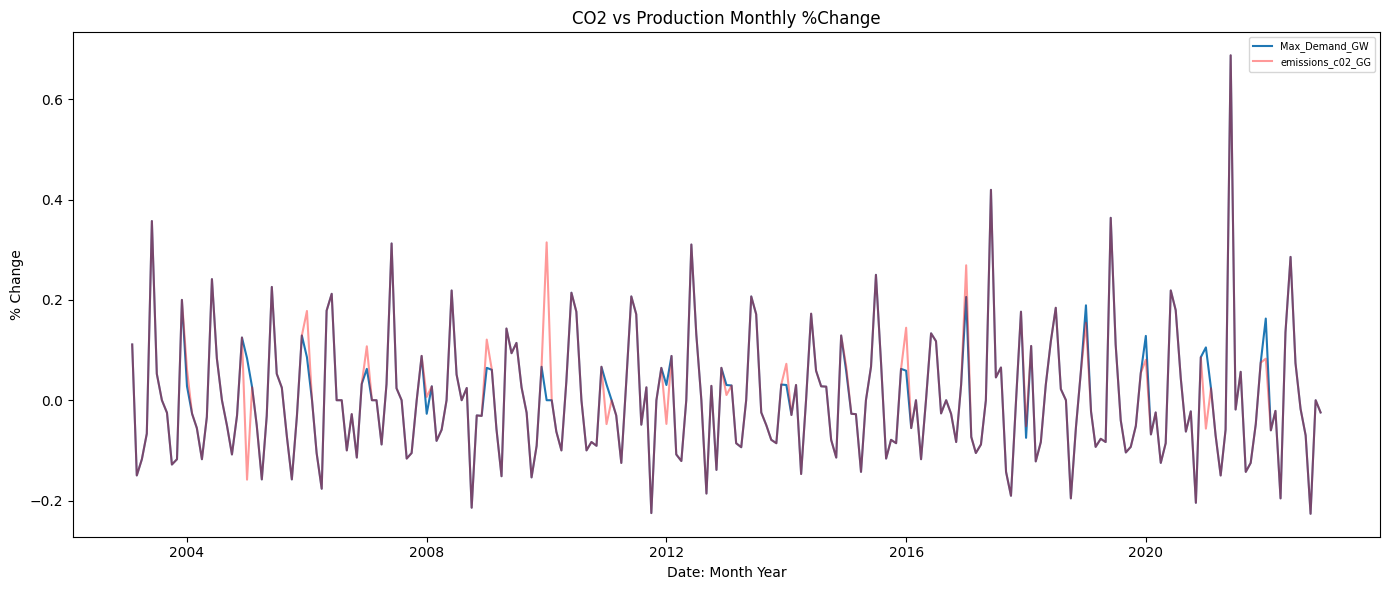

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(all_data_df[ELEC_DMD_COL].pct_change(), label=ELEC_DMD_COL, alpha=1)
ax.plot(c02_df[CO2_COL].pct_change(), label=CO2_COL, alpha=0.4, color="r")
ax.set_xlabel("Date: Month Year")
ax.set_ylabel("% Change")
ax.set_title("CO2 vs Production Monthly %Change")
ax.legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

In [6]:
SELECTED_FEATURES.append(CO2_COL)

all_data_df[CO2_COL] = c02_df[CO2_COL]
all_data_df[SELECTED_FEATURES].head(3)

,Max_Demand_GW,Plant_Production_GWh,emissions_c02_GG
Date,,,
2003-01-01,0.36,182.08,47.52
2003-02-01,0.40,187.10,52.80
2003-03-01,0.34,176.37,44.88


## GDP

Gross domestic product is a monetary measure of the market value of all the final goods and services produced in a specific time period by a country or countries.

Therefore the most logical way to increase granularity would be to distribute it according to the Plant_Production_GWh. In loose terms, this assumes that the more the economy is generating, the more energy is being consumed.

For data assurance, Malta should have ended 2022 with 16 Billion Euros in GDP, reference [here](https://nso.gov.mt/gross-domestic-product-2022/).

In the timeseries the plot is not smooth, this is as a result of our resampling. 

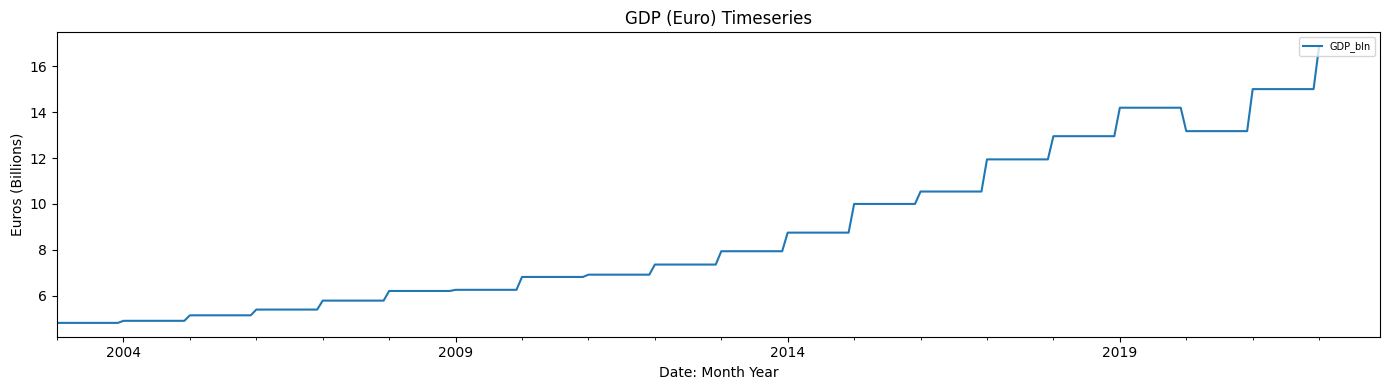

In [7]:
GDP_DS = "gdp_EUR.csv"
GDP_COL = "GDP_bln"
UNIT_TO_BILLIONS = 1000000000

gdp_df = pd.read_csv(f"{RAW_DATA_PATH}/{GDP_DS}")
gdp_df = gdp_df.T
gdp_df.columns = [GDP_COL]
gdp_df[GDP_COL] = gdp_df[GDP_COL].apply(lambda x: round(x / UNIT_TO_BILLIONS, 2))

# Indexed on year only, resample to monthly. interpolate everything.
gdp_df.index = pd.to_datetime(gdp_df.index, format="%Y")
gdp_df = gdp_df.resample("MS").ffill()

gdp_df = gdp_df[(gdp_df.index >= START_DATE) & (gdp_df.index <= END_DATE)]

SELECTED_FEATURES.append(GDP_COL)
all_data_df[GDP_COL] = round(gdp_df[GDP_COL], 2).interpolate().ffill().bfill()

# Visually check timeseries is healthy.
fig, ax = plt.subplots(figsize=(14, 4))
all_data_df[GDP_COL].plot(kind="line", ax=ax)
ax.set_xlabel("Date: Month Year")
ax.set_ylabel("Euros (Billions)")
ax.set_title("GDP (Euro) Timeseries")
ax.legend([GDP_COL], fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

# Population

Population is a stock figure at the end of the year, therefore it can be interpolated by distributing the CHANGE in population in a year over the period.

The last year in the data set, 2022, cannot be interpolated therefore the population is assumed constant for the whole year.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


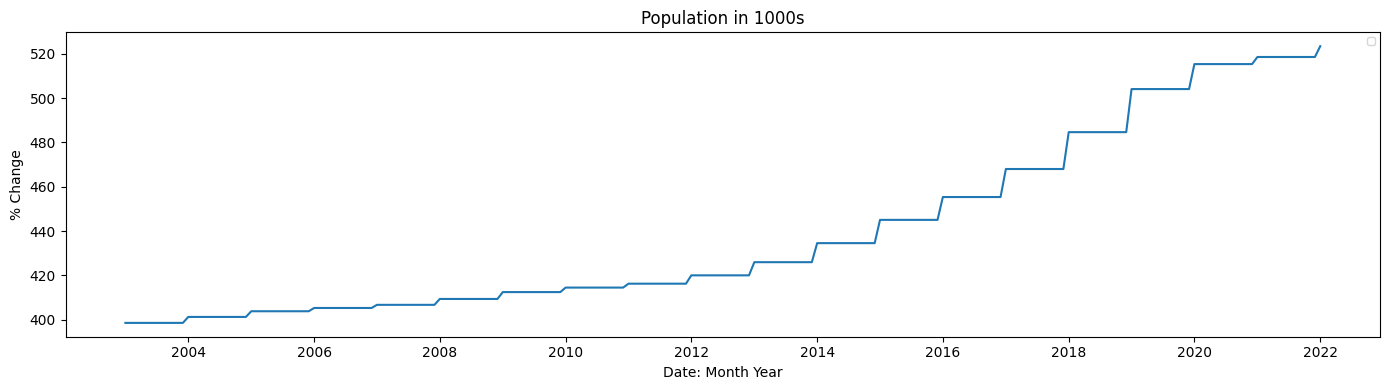

,Max_Demand_GW,Plant_Production_GWh,emissions_c02_GG,GDP_bln,Population_k
Date,,,,,
2022-10-01,0.41,225.89,53.28,NaN,523.42
2022-11-01,0.41,206.40,53.28,NaN,523.42
2022-12-01,0.40,207.78,51.98,NaN,523.42


In [8]:
POP_DS = "malta_population.csv"
POP_COL = "Population_k"
UNIT_TO_THOUSAND = 1000

pop_df = pd.read_csv(f"{RAW_DATA_PATH}/{POP_DS}")
pop_df = pop_df.T
pop_df.columns = [POP_COL]
pop_df[POP_COL] = pop_df[POP_COL] / UNIT_TO_THOUSAND

# Indexed on year only, resample to monthly. interpolate everything.
pop_df.index = pd.to_datetime(pop_df.index, format="%Y")
pop_df = pop_df.resample("MS").ffill()
pop_df = pop_df[(pop_df.index >= START_DATE) & (pop_df.index <= END_DATE)]

plt.figure(figsize=(14, 4))
plt.plot(pop_df)
plt.xlabel("Date: Month Year")
plt.ylabel("% Change")
plt.title("Population in 1000s")
plt.legend(fontsize=7, loc="upper right")
plt.tight_layout()
plt.show()

SELECTED_FEATURES.append(POP_COL)

# Population is missing the last months from the resample.
all_data_df[POP_COL] = pop_df[POP_COL]
all_data_df[POP_COL] = round(all_data_df[POP_COL], 2).interpolate().ffill().bfill()
all_data_df[SELECTED_FEATURES].tail(3)

## Climate

Climate is pulled fromm the meteostat SDK.

In [9]:
from meteostat import Point, Monthly

# latitude and longitude for Malta
malta = Point(35.8992, 14.5141)
temp_data_df = Monthly(malta, START_DATE, END_DATE)
temp_data_df = temp_data_df.fetch()
temp_data_df = temp_data_df[
    (temp_data_df.index >= START_DATE) & (temp_data_df.index <= END_DATE)
]

temp_data_df.index = pd.to_datetime(temp_data_df.index, format="%Y-%m-%d")
temp_data_df = temp_data_df.interpolate().bfill()
temp_data_df.head(3)

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
2003-01-01,13.2,10.9,15.6,152.0,12.5,1014.9,9900.0
2003-02-01,10.4,7.9,13.0,150.0,12.5,1016.7,8280.0
2003-03-01,12.7,9.8,15.7,55.0,12.5,1020.6,13920.0


 It's data quality is moderate, features like precipitation display extreme outliers, while minimum temperature and sun measurements have gaps in our date ranges.

 We will select only maximum and average temperatures for our data. Windspeed would have been relevant if we had windfarms.

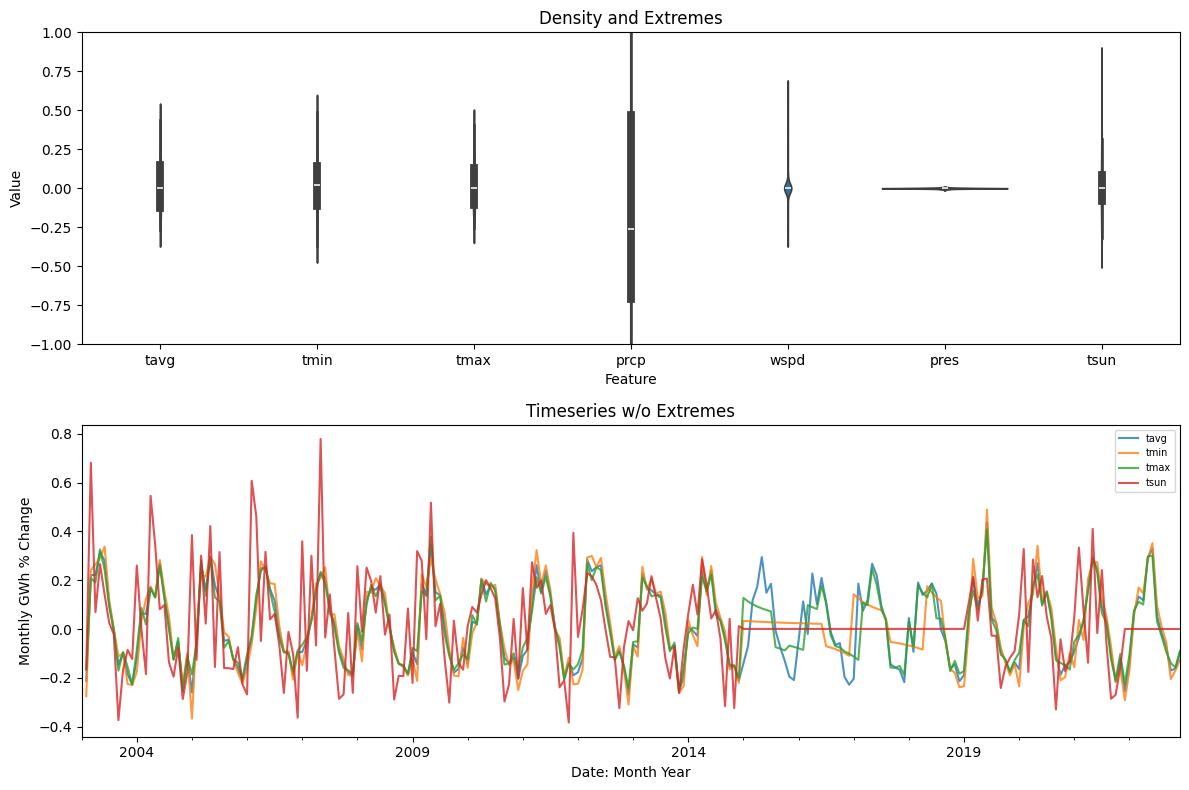

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

melted_df = temp_data_df.pct_change().ffill().reset_index().melt(id_vars=["time"])
melted_df.rename(
    columns={"index": "Date", "variable": "Feature", "value": "Value"}, inplace=True
)
sns.violinplot(x="Feature", y="Value", data=melted_df, ax=axes[0])
axes[0].set_title("Density and Extremes")
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Value")
axes[0].set_ylim([-1, 1])

temp_data_df.drop(columns=["prcp", "wspd", "pres"], axis=1).pct_change().ffill().plot(
    kind="line", ax=axes[1], alpha=0.8
)
axes[1].set_xlabel("Date: Month Year")
axes[1].set_ylabel("Monthly GWh % Change")
axes[1].set_title("Timeseries w/o Extremes")
axes[1].legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

In [11]:
TEMP_MAX_COL = "tmax"
TEMP_AVG_COL = "tavg"
SELECTED_FEATURES.append(TEMP_AVG_COL)
SELECTED_FEATURES.append(TEMP_MAX_COL)
all_data_df = pd.concat(  # Tmin for the other models that are using it?
    [all_data_df, temp_data_df[[TEMP_AVG_COL, TEMP_MAX_COL, "tmin"]]],
    axis=1,
    ignore_index=False,
)
all_data_df = all_data_df.interpolate().ffill().fillna(0)
all_data_df[SELECTED_FEATURES].tail(3)

,Max_Demand_GW,Plant_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tavg,tmax
2022-10-01,0.41,225.89,53.28,16.87,523.42,21.5,25.3
2022-11-01,0.41,206.40,53.28,16.87,523.42,18.0,21.3
2022-12-01,0.40,207.78,51.98,16.87,523.42,16.3,19.4


# Visualize All Timeseries

All features are a timeseries, which means there is a patteren across time. 

We assume, upward/downward trends, and spikes or dips according to the month in the year (seasonality). Plotting to verify these assumptions:

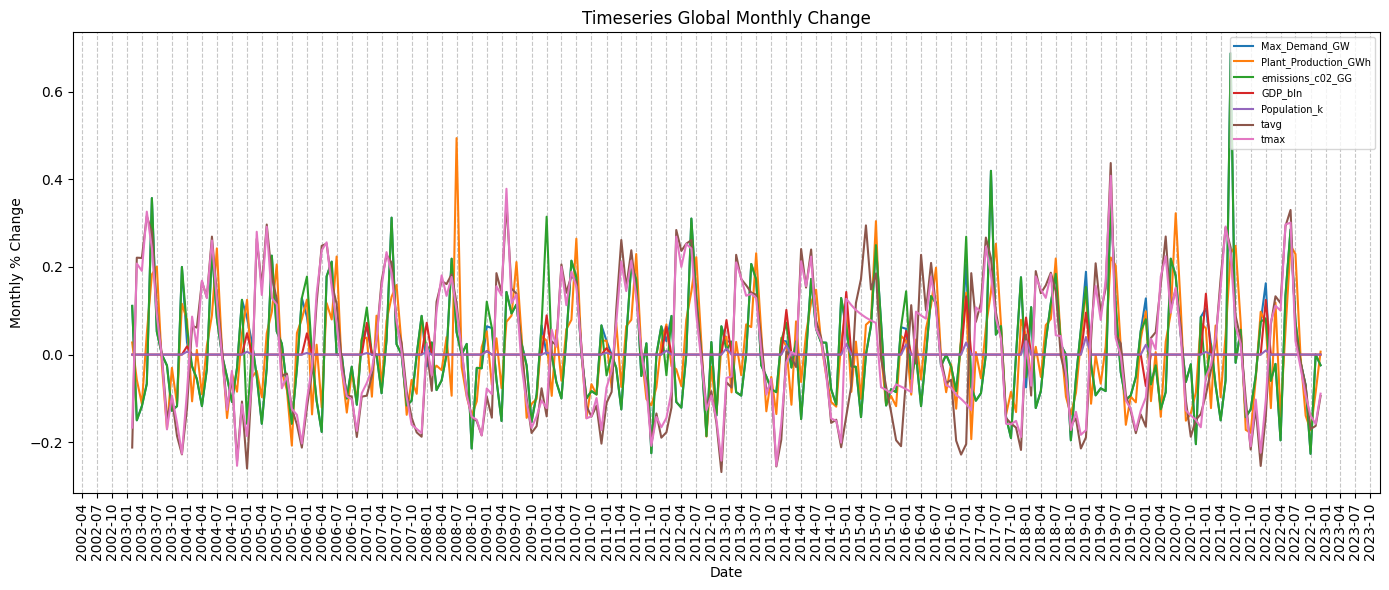

In [12]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14, 6))  # Adjusted for a single plot
for feature in SELECTED_FEATURES:
    ax.plot(all_data_df[feature].pct_change().ffill(), label=feature)

ax.set_xlabel("Date")
ax.set_ylabel("Monthly % Change")
ax.grid(axis="x", linestyle="--", alpha=0.7)
ax.tick_params(axis="x", rotation=90)
# See: https://matplotlib.org/stable/api/dates_api.html
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_title("Timeseries Global Monthly Change")
ax.legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

## Visualize Patterns

Pair plot all data to see its shape and note patterns. We will do it for all the dataset, although we have curated a select feature set, we will view everything together.

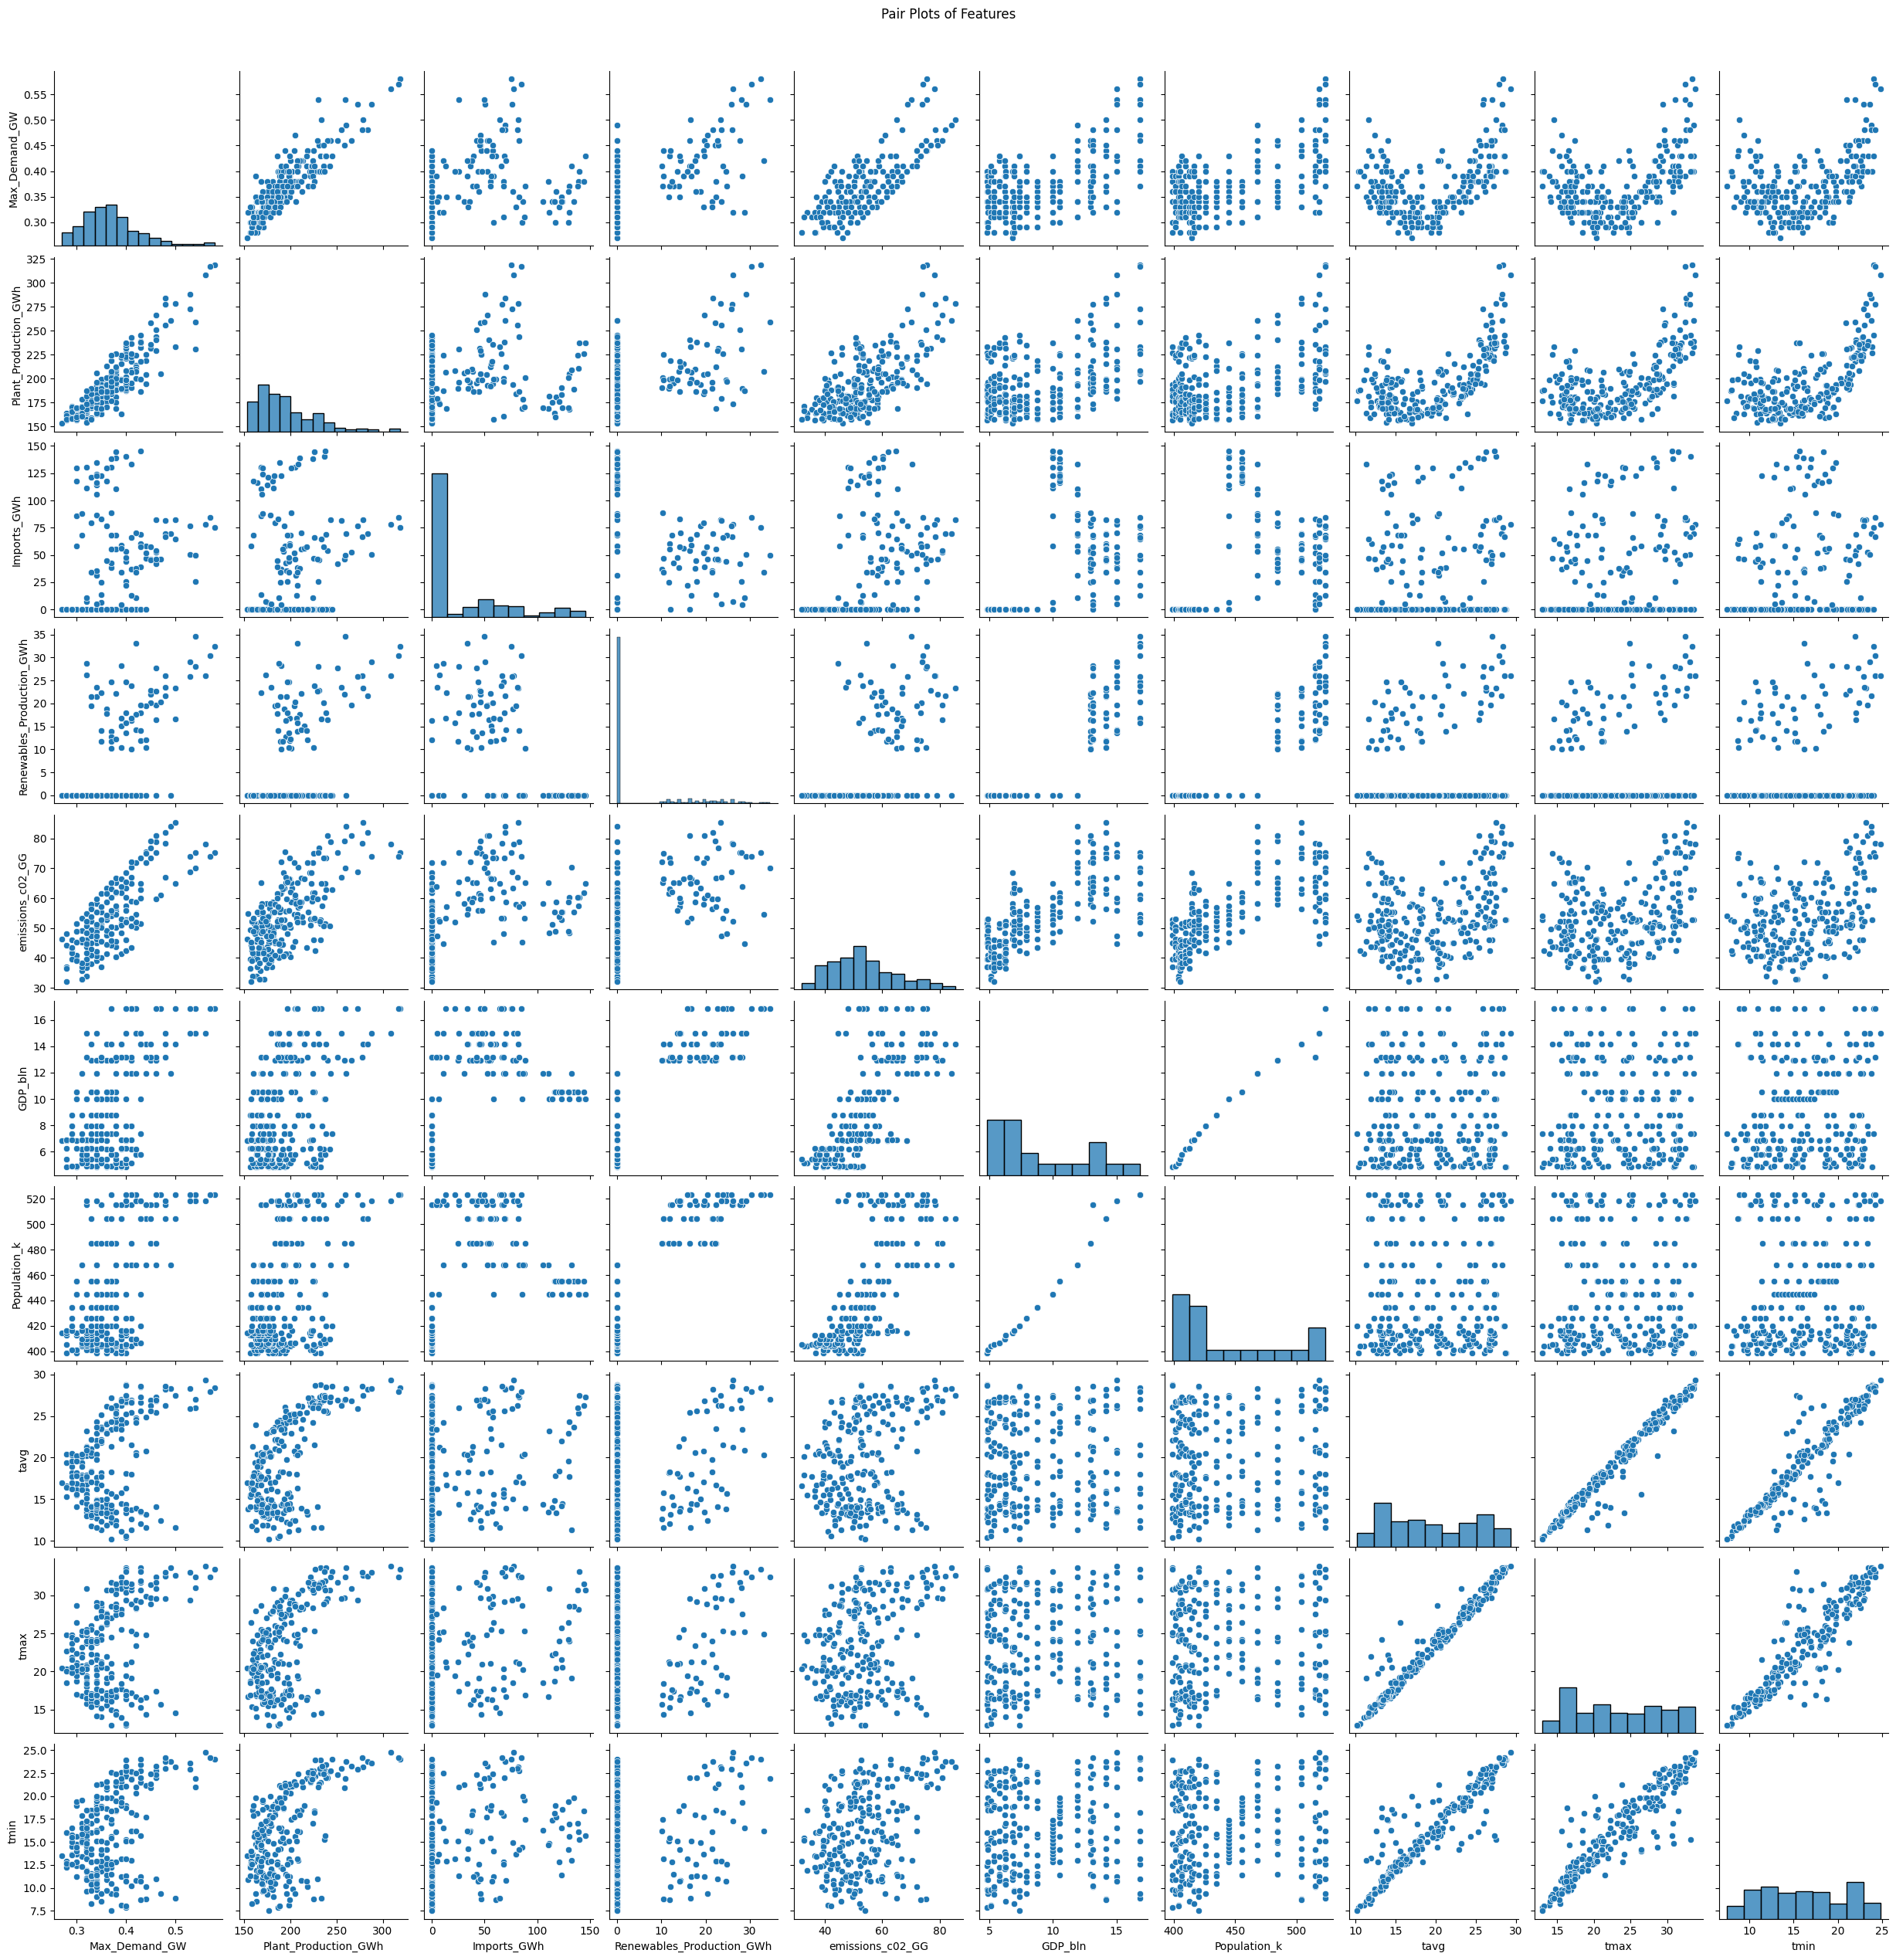

In [13]:
sns.pairplot(all_data_df)
plt.suptitle("Pair Plots of Features", y=1.02)
plt.show()

Obversations:
- *Demand and Production* are similar in patterns and relationships. Production is the output overtime while demand is the highest instantenous output done. These might be multicollinear.
- *GDP* index has some relationship with *population* and *emissions*. There might be multicollinearity. This would be ideally reduced to [GDP per Capita](https://www.investopedia.com/terms/p/per-capita-gdp.asp#:~:text=GDP%20per%20capita%20is%20calculated,a%20nation%20by%20its%20population.).
- The climate data in *tmax*, and *tavg* is obviously multicollinear and have a quadratic relationship with the *Demand*. We will select *tavg* for our models.


## Data Relationships' Statistical Tests

Are the moves of statistical significance or arbitary. We will test the correlations, to assure these are not artbiary and we will test for significant cointegration betweent the various features. 

We have 2 hypothesis tested at $\alpha$ of `0.05`:
1. $H0_1$: Features are not correlated, or not in a significant way.
2. $H0_2$: Timeseries features are not cointegrated, or not in a significant way.

We prepare the tests:

In [14]:
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import coint

CR_THRESHOLD = 0.75
P_THRESHOLD = 0.05

corr_matrix = np.zeros((len(all_data_df.columns), len(all_data_df.columns)))
coint_matrix = np.zeros((len(all_data_df.columns), len(all_data_df.columns)))
p_value_matrix = np.zeros((len(all_data_df.columns), len(all_data_df.columns)))

for i, feature1 in enumerate(all_data_df.columns):
    for j, feature2 in enumerate(all_data_df.columns):
        assert len(all_data_df[feature1]) == len(all_data_df[feature2])
        if i == j:
            # to avoid the colinearity warnings.
            corr_matrix[i, j] = 1
            continue
        pr_obj = pearsonr(all_data_df[feature1], all_data_df[feature2])
        corr_matrix[i, j] = pr_obj[0]
        p_value_matrix[i, j] = pr_obj[1]
        coint_result = coint(all_data_df[feature1], all_data_df[feature2])
        coint_matrix[i, j] = coint_result[1]

corr_df = pd.DataFrame(
    corr_matrix, index=all_data_df.columns, columns=all_data_df.columns
)
p_value_df = pd.DataFrame(
    p_value_matrix, index=all_data_df.columns, columns=all_data_df.columns
)
coint_df = pd.DataFrame(
    coint_matrix, index=all_data_df.columns, columns=all_data_df.columns
)

And create  heatmaps below to visualize the results:

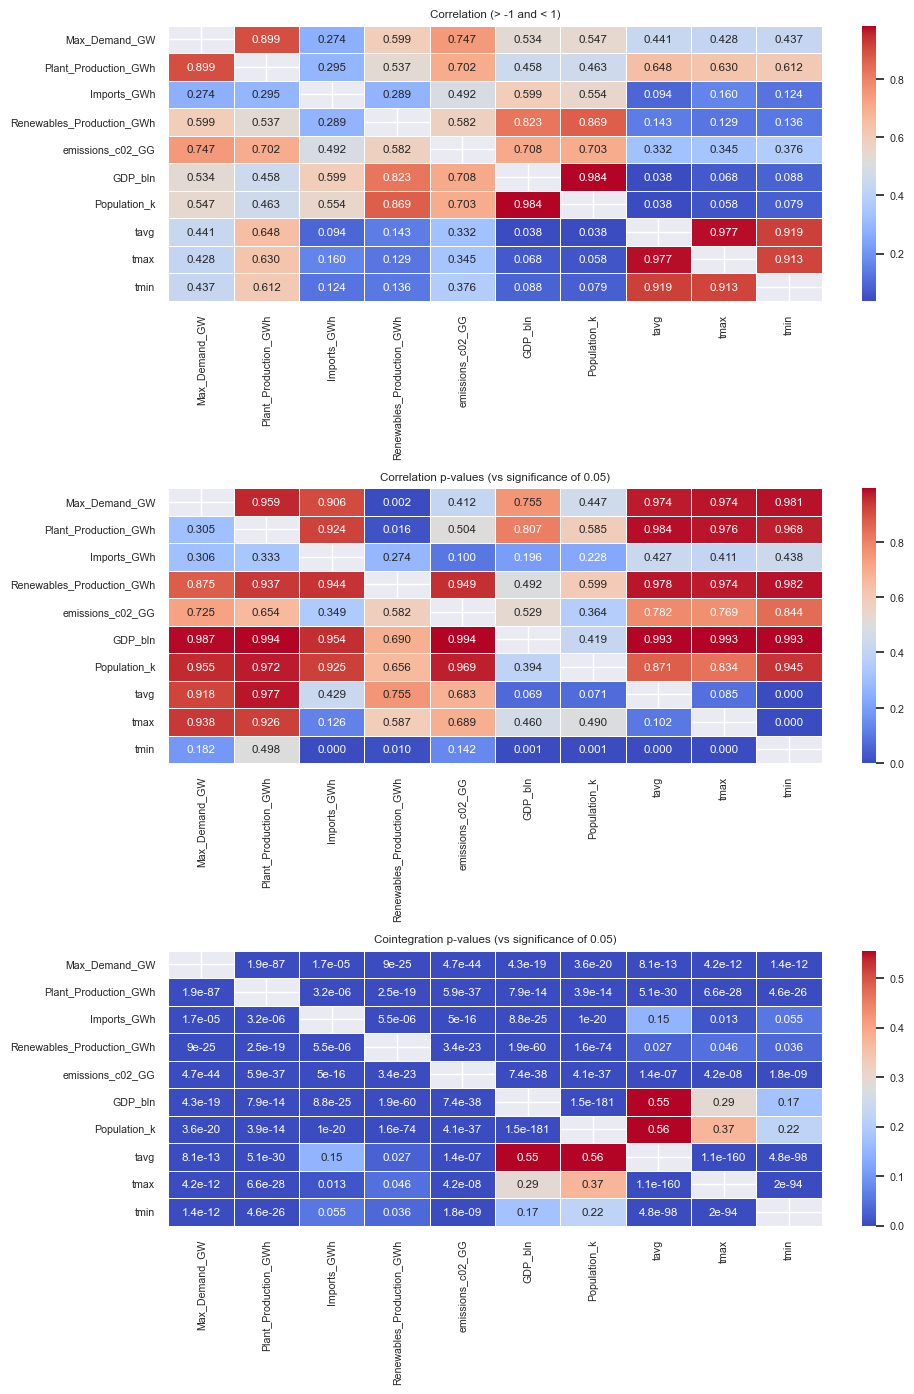

In [15]:
sns.set(font_scale=0.7)

plt.figure(figsize=(10, 14))
plt.subplot(3, 1, 1)
sns.heatmap(
    corr_df, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5, mask=(corr_df == 1)
)
plt.title(f"Correlation (> -1 and < 1)")
plt.subplot(3, 1, 2)
sns.heatmap(
    coint_df,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    linewidths=0.5,
    mask=(coint_df == 0),
)
plt.title(f"Correlation p-values (vs significance of 0.05)")
plt.subplot(3, 1, 3)
# these are so small we should scale visually.
sns.heatmap(
    p_value_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2",
    linewidths=0.5,
    mask=(p_value_df == 0),
)
plt.title(f"Cointegration p-values (vs significance of 0.05)")
plt.tight_layout()
plt.show()

Results of the hypothesis tests:

1. $H0_0$ is not rejected for features:
   1. *tvag*, *tmin*, and *tmax*
   2. *population* and *gdp*
   3. The other correlation might be spurious within our samples.
2. $H0_1$ is rejected across all features except with the average temperature with GDP and popoulation - meaning this cointegration might be spurious.

Observations:
- *tvag*, *tmin*, & *tmax*, and *population*, & *gdp*, are probably multicolinear we will perform VIF to verify this.
- *population* and *gdp* are best represented with the proxy *GDP per Capita* as we will do below.
- Strong cointegration means there is an equilibrium relationship between features, and all affect each other and have a common **long-term trend**.
- Strong cointegration without Strong correlation (or statistical significant one) might hint at external factors influencing the features which we haven't discovered.
- Strong correlation but asymmetric p-values between demand and production. This hints at a directional relationship between the two. Max Demand drives Electricity Production but not the other way around.

## Multicolinearity and Variance Inflation Factor (VIF)

The only high correlation we observed is between demand and production, though for statistical rigour, we will test the features with moderate correlation amongst each other using [Variance Inflation Factor (VIF)](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html) and a constant [predictor](https://www.statsmodels.org/devel/generated/statsmodels.tools.tools.add_constant.html). 

For feature not to be colinear, they have to score between 1 to 5.

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_with_constant = add_constant(all_data_df.drop([ELEC_DMD_COL], axis=1))
vif_data = pd.DataFrame()
vif_data["feature"] = data_with_constant.columns
vif_data["VIF"] = [
    variance_inflation_factor(data_with_constant.values, i)
    for i in range(data_with_constant.shape[1])
]

print(vif_data)

                     feature          VIF
0                      const  3874.527368
1       Plant_Production_GWh     3.828952
2                Imports_GWh     2.168189
3  Renewables_Production_GWh     7.198286
4           emissions_c02_GG     3.560766
5                    GDP_bln    41.068075
6               Population_k    52.913644
7                       tavg    30.208365
8                       tmax    26.011302
9                       tmin     7.047647


With this analysis we can hint which are the right features to us.

The results below show we have no multicolinearity in our selected features:

In [17]:
SELECTED_FEATURES = [ELEC_DMD_COL, ELEC_PROD_COL, CO2_COL, TEMP_AVG_COL, GDP_COL]
print(SELECTED_FEATURES)

data_with_constant = add_constant(
    all_data_df[SELECTED_FEATURES].drop([ELEC_DMD_COL], axis=1)
)
vif_data = pd.DataFrame()
vif_data["feature"] = data_with_constant.columns
vif_data["VIF"] = [
    variance_inflation_factor(data_with_constant.values, i)
    for i in range(data_with_constant.shape[1])
]

print(vif_data)

['Max_Demand_GW', 'Plant_Production_GWh', 'emissions_c02_GG', 'tavg', 'GDP_bln']
                feature        VIF
0                 const  41.414577
1  Plant_Production_GWh   3.254342
2      emissions_c02_GG   3.147532
3                  tavg   2.020309
4               GDP_bln   2.242182




# Output Clean Dataset

Store the train and test sets for models to experiment on.

As these are timeseries, no random splits should be done.

In [18]:
all_data_df.sort_index(inplace=True)
all_data_df.index.name = "Date"
all_data_df.to_csv("./data/all_data.csv", index=True)

TRAIN_PERC = 0.8
TEST_PERC = 0.2
train_size = int(len(all_data_df) * TRAIN_PERC)
test_size = int(len(all_data_df) * TEST_PERC)

train_df = all_data_df.iloc[:train_size]
test_df = all_data_df.iloc[train_size : train_size + test_size]

train_df.to_csv("./data/train_data.csv", index=True)
test_df.to_csv("./data/test_data.csv", index=True)